# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from scipy.stats import ks_2samp



In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
def gerar_analise_bivariada_binaria(df: pd.DataFrame, var_categorica: str, var_resposta_binaria: str) -> pd.DataFrame:
    '''
    Gera uma análise bivariada entre uma variável categórica e uma variável binária.
    Esta função recebe um dataframe e o nome de uma variável categórica e uma variável contínua binária

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        var_categorica (str): Nome da variável categórica.
        var_resposta_binaria (str): Nome da variável resposta binária.

    Retorna:
        pd.DataFrame: DataFrame contendo a análise bivariada com contagens, percentuais, odds, odds ratio, logito e WOE.
    '''

    ### Validações iniciais
    if df.empty:
        raise ValueError('O DataFrame fornecido está vazio.')
    if var_categorica not in df.columns:
        raise ValueError('A variável categórica fornecida não está presente no DataFrame.')
    if var_resposta_binaria not in df.columns:
        raise ValueError('A variável contínua fornecida não está presente no DataFrame.')
    
    ### Análise bivariada
    bivar = pd.crosstab(index=df[var_categorica], 
                        columns=df[var_resposta_binaria], 
                        margins=True)
    bivar[f'percent_{var_resposta_binaria}'] = bivar[1] / bivar['All']
    bivar[f'odds_{var_resposta_binaria}'] = bivar[1] / bivar[0]
    bivar[f'odds_ratio_{var_resposta_binaria}'] = bivar[f'odds_{var_resposta_binaria}'] / bivar.loc['All', f'odds_{var_resposta_binaria}']
    bivar[f'logito_{var_resposta_binaria}'] = np.log(bivar[f'odds_{var_resposta_binaria}'])
    bivar[f'WOE_{var_resposta_binaria}'] = np.log( (bivar[1] / bivar.loc['All', 1]) / (bivar[0] / bivar.loc['All', 0]) )
    return bivar

In [5]:
gerar_analise_bivariada_binaria(df, 'sex', 'flag_doente')

flag_doente,0,1,All,percent_flag_doente,odds_flag_doente,odds_ratio_flag_doente,logito_flag_doente,WOE_flag_doente
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [6]:
def gerar_analise_bivariada_continua(df: pd.DataFrame, var_categorica_continua: str, var_resposta_binaria: str, num_de_categorias:int = 5) -> pd.DataFrame:
    '''
    Gera uma análise bivariada entre uma variável contínua e uma variável binária.
    Esta função recebe um dataframe e o nome de uma variável contínua e uma variável binária

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        var_categorica_continua (str): Nome da variável contínua.
        var_resposta_binaria (str): Nome da variável resposta binária.
        num_de_categorias (int): Número de categorias para dividir a variável contínua.

    Retorna:
        pd.DataFrame: DataFrame contendo a análise bivariada com contagens, percentuais, odds, odds ratio, logito e WOE.
    '''

    ### Validações iniciais
    if df.empty:
        raise ValueError('O DataFrame fornecido está vazio.')   
    if var_categorica_continua not in df.columns:
        raise ValueError('A variável contínua fornecida não está presente no DataFrame.')
    if var_resposta_binaria not in df.columns:
        raise ValueError('A variável binária fornecida não está presente no DataFrame.')
    if not pd.api.types.is_numeric_dtype(df[var_categorica_continua]):
        raise ValueError('A variável contínua fornecida não é numérica.')
    if num_de_categorias < 2:
        raise ValueError('O número de categorias deve ser pelo menos 2.')
    
    ### Análise bivariada
    bivar = pd.crosstab(index = pd.qcut(df[var_categorica_continua], q=num_de_categorias, duplicates='drop'), 
                        columns = df[var_resposta_binaria],
                        margins=True)
    bivar[f'percent_{var_resposta_binaria}'] = bivar[1] / bivar['All']
    bivar[f'odds_{var_resposta_binaria}'] = bivar[1] / bivar[0]
    bivar[f'odds_ratio_{var_resposta_binaria}'] = bivar[f'odds_{var_resposta_binaria}'] / bivar.loc['All', f'odds_{var_resposta_binaria}']
    bivar[f'logito_{var_resposta_binaria}'] = np.log(bivar[f'odds_{var_resposta_binaria}'])
    bivar[f'WOE_{var_resposta_binaria}'] = np.log( (bivar[1] / bivar.loc['All', 1]) / (bivar[0] / bivar.loc['All', 0]) )
    return bivar

In [7]:
gerar_analise_bivariada_continua(df, 'age', 'flag_doente', 5)

flag_doente,0,1,All,percent_flag_doente,odds_flag_doente,odds_ratio_flag_doente,logito_flag_doente,WOE_flag_doente
age,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [8]:
reglog = smf.logit(formula='flag_doente ~ sex + cp + trestbps + age', data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Sun, 26 Oct 2025   Pseudo R-squ.:                  0.2605
Time:                        21:50:38   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.331      5.444      0.000       1.153       2.451
cp             1.1403      0.169      6.739      0.000       0.809       1.472
trestbps       0.0214      0.008      2.600      0.009       0.005       0.037
age            0.0582      0.017      3.348      0.001       0.024       0.092
==============================================================================
"""

In [9]:
reglog.params

Intercept   -11.116719
sex           1.802110
cp            1.140272
trestbps      0.021374
age           0.058156
dtype: float64

In [10]:
eta = np.sum(reglog.params)
odd = np.exp(eta)
probabilidade = 1/(1+np.exp(-eta))

print(f"Probabilidade calculada a partir do eta (soma dos betas): {probabilidade:.4f}")
print("-" * 50)
print(f"Chance (Odds Ratio) para o Intercepto: {np.exp(reglog.params.iloc[0]):.4f}")
print(f"Chance (Odds Ratio) para 'sex' (homem vs. mulher): {np.exp(reglog.params.iloc[1]):.4f}")
print(f"Chance invertida para 'sex' (mulher vs. homem): {1/np.exp(reglog.params.iloc[1]):.4f}")
print(f"Chance (Odds Ratio) para cada unidade de 'cp': {np.exp(reglog.params.iloc[2]):.4f}")
print(f"Chance (Odds Ratio) para cada unidade de 'trestbps': {np.exp(reglog.params.iloc[3]):.4f}")
print(f"Chance (Odds Ratio) para cada ano de 'age': {np.exp(reglog.params.iloc[4]):.4f}")

Probabilidade calculada a partir do eta (soma dos betas): 0.0003
--------------------------------------------------
Chance (Odds Ratio) para o Intercepto: 0.0000
Chance (Odds Ratio) para 'sex' (homem vs. mulher): 6.0624
Chance invertida para 'sex' (mulher vs. homem): 0.1650
Chance (Odds Ratio) para cada unidade de 'cp': 3.1276
Chance (Odds Ratio) para cada unidade de 'trestbps': 1.0216
Chance (Odds Ratio) para cada ano de 'age': 1.0599


4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [11]:
df['pred_prob'] = reglog.predict(df)
df['pred_group'] = pd.qcut(df['pred_prob'], q=5, duplicates='drop')

group_reg = df.groupby('pred_group', observed=False)
qualid = group_reg[['flag_doente']].count().rename(columns={'flag_doente': 'n_obs'})
qualid['pred_group'] = group_reg['pred_prob'].mean()
qualid['pct_evento'] = group_reg['flag_doente'].mean()

qualid

,n_obs,pred_group,pct_evento
pred_group,,,
"(0.0119, 0.146]",61,0.076255,0.098361
"(0.146, 0.349]",60,0.249060,0.183333
"(0.349, 0.575]",61,0.457982,0.491803
"(0.575, 0.772]",60,0.673059,0.683333
"(0.772, 0.928]",61,0.837449,0.836066


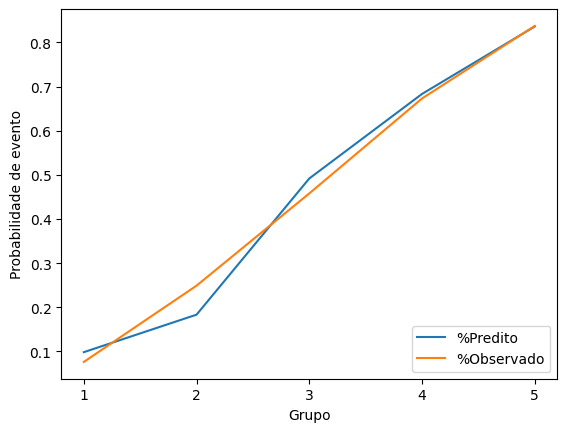

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['pct_evento'].plot(label='%Predito')
ax = qualid['pred_group'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')
plt.show()
plt.close()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

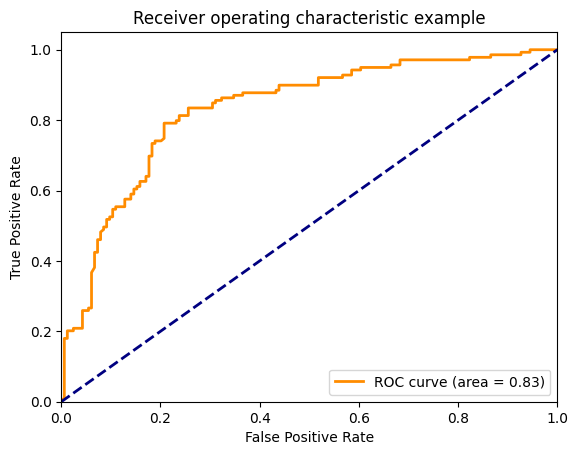

In [13]:

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['pred_prob'])
auc_ = metrics.auc(fpr, tpr)

plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
plt.close()

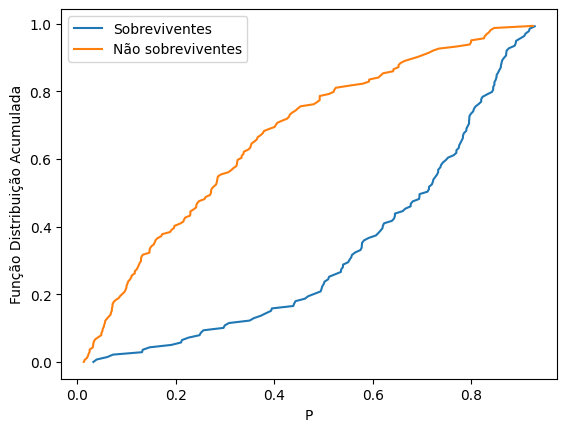

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'pred_prob']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Sobreviventes')

score_pop2 = df.loc[df['flag_doente']!=1,'pred_prob']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Não sobreviventes')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

plt.show()
plt.close()

In [15]:
acc = metrics.accuracy_score(df['flag_doente'], df['pred_prob']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['pred_prob'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'pred_prob'], df.loc[df['flag_doente'] != 1, 'pred_prob']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 77.89%
KS: 58.40% 
AUC: 83.11% 
GINI: 66.22%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

Optimization terminated successfully.
         Current function value: 0.448501
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      295
Method:                           MLE   Df Model:                            7
Date:                Sun, 26 Oct 2025   Pseudo R-squ.:                  0.3498
Time:                        21:50:39   Log-Likelihood:                -135.90
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 2.560e-28
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7668      2.247     -2.567      0.010     -10.170      -1.364
sex            1.9741      0.

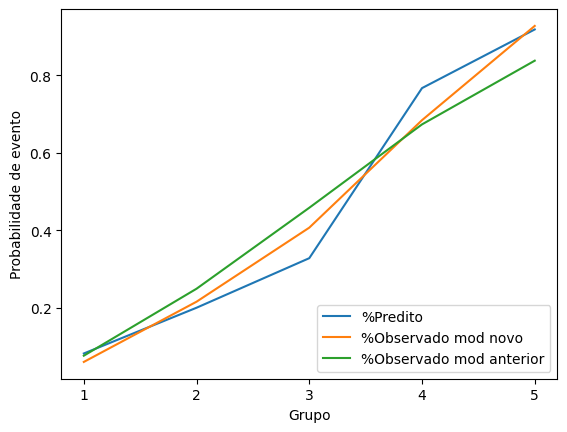


--- Métricas de Discriminação (Modelo V2) ---
Acurácia: 0.7987
AUC: 0.8702
GINI: 0.7405
KS: 0.6180

--- Comparação ---
GINI anterior: 0.6622
GINI novo: 0.7405


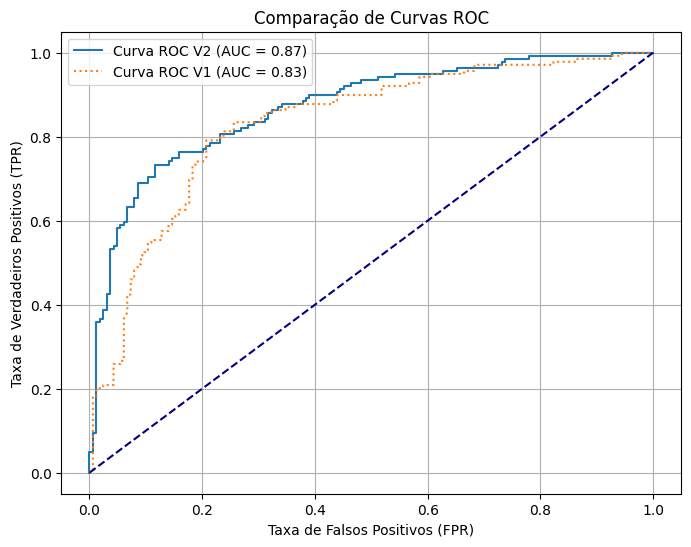

In [ ]:
formula_v2 = 'flag_doente ~ sex + cp + trestbps + age + chol + thalach + exang'
reglog_v2 = smf.logit(formula=formula_v2, data=df).fit()
print(reglog_v2.summary())

df['pred_prob_v2'] = reglog_v2.predict(df)
df['pred_group_v2'] = pd.qcut(df['pred_prob_v2'], q=5, duplicates='drop')

group_reg_v2 = df.groupby('pred_group_v2', observed=False)
qualid_v2 = group_reg_v2[['flag_doente']].count().rename(columns={'flag_doente': 'n_obs'})
qualid_v2['pred_group_v2'] = group_reg_v2['pred_prob_v2'].mean()
qualid_v2['pct_evento'] = group_reg_v2['flag_doente'].mean()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid_v2['pct_evento'].plot(label='%Predito')
ax = qualid_v2['pred_group_v2'].plot(label='%Observado mod novo')
ax = qualid['pred_group'].plot(label='%Observado mod anterior')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')
plt.show()
plt.close()


fpr_v2, tpr_v2, thresholds_v2 = roc_curve(df['flag_doente'], df['pred_prob_v2'])

df['pred_class_v2'] = (df['pred_prob_v2'] > 0.5).astype(int)
acc_v2 = accuracy_score(df['flag_doente'], df['pred_class_v2'])

auc_v2 = roc_auc_score(df['flag_doente'], df['pred_prob_v2'])
gini_v2 = 2 * auc_v2 - 1

fpr_v2, tpr_v2, thresholds_v2 = roc_curve(df['flag_doente'], df['pred_prob_v2'])
ks_v2 = max(tpr_v2 - fpr_v2)

print(f"\n--- Métricas de Discriminação (Modelo V2) ---")
print(f"Acurácia: {acc_v2:.4f}")
print(f"AUC: {auc_v2:.4f}")
print(f"GINI: {gini_v2:.4f}")
print(f"KS: {ks_v2:.4f}")


print(f"\n--- Comparação ---")
print(f"GINI anterior: {gini:.4f}")
print(f"GINI novo: {gini_v2:.4f}")


plt.figure(figsize=(8, 6))
plt.plot(fpr_v2, tpr_v2, label=f'Curva ROC V2 (AUC = {auc_v2:.2f})')
plt.plot(fpr, tpr, label=f'Curva ROC V1 (AUC = {auc_:.2f})', linestyle=':')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Comparação de Curvas ROC')
plt.legend()
plt.grid(True)
plt.show()

### Com isso concluo a tarefa 2 do mod 18 !